#### No powerlaw removal on this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from itertools import chain
from sys import platform
from copy import deepcopy as dc
from scipy.interpolate import interp1d
from astropy.time import Time

vims_wave = np.loadtxt('vims_wave.txt')

new_array = ['_0405','_0607','_0809','_1011','_1213','_1415','_1617']
if platform == 'darwin' or platform == 'win32' or platform == 'linux':
    for number in new_array:
        new_string = 'df'+number+' = pd.read_pickle("total_data/data'+number+'.pkl")'
        exec(new_string)
else:
    df_list = []
    for number in new_array:
        new_string = 'df'+number+' = pd.read_csv("total_data/data'+number+'.csv")'
        exec(new_string)
        df_list.append(locals()['df'+number])
    for df in df_list:
        for i in range(len(df['spectrum'])):
            df['spectrum'][i] = np.array([float(x) for x in df['spectrum'][i][1:-1].split(',')])

vims_list = []
for i in range(4,18):
    if i<10:
        exec('vims_200'+str(i)+' = np.load("vims_shift/vims_200'+str(i)+'.npy")')
        vims_list.append(locals()['vims_200'+str(i)])
    else:
        exec('vims_20'+str(i)+' = np.load("vims_shift/vims_20'+str(i)+'.npy")')
        vims_list.append(locals()['vims_20'+str(i)])

def powerlaw(x,a,b):
    return a*np.power(x,b)

def gaussian(x,a,mu,sigma):
    return a*np.exp(-(x-mu)**2/(2*sigma**2))

def flatten(some_list):
    flat_list = []
    for element in some_list:
        if type(element) is list or type(element) is tuple:
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

band_channels = list(chain(range(29,35),range(46,60),range(78,96),range(102,106)))

window = list(range(56,83))

def fit_line(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_fit = powerlaw(vims_wave,*my_fit)
    return final_fit

def custom_fit(dataframe):
    spectra = np.average(dataframe)
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectra[band_channels],p0=[.15,-12])
    final_spectra = spectra-powerlaw(vims_wave,*my_fit)
    return final_spectra

def single_fit(spectrum):
    my_fit,_ = curve_fit(powerlaw,vims_wave[band_channels],spectrum[band_channels],p0=[.15,-12])
    final_spectrum = spectrum-powerlaw(vims_wave,*my_fit)
    return final_spectrum

def shift_ret(spectrum):
    my_fit,_ = curve_fit(gaussian,vims_wave[window],spectrum[window],p0=[.05,2.05])
    return my_fit[1]

In [2]:
scatter_list = []
for number in new_array:
    my_string = 'scatter'+number+" = df"+number
    exec(my_string)
    scatter_list.append(locals()['scatter'+number])

airmass_data = pd.concat(scatter_list,ignore_index=True)

all_spectra = airmass_data['spectrum']

airmass_data['emission'] *= (np.pi)/180
airmass_data['incidence'] *= (np.pi)/180

spec_list = []
for number in new_array:
    my_string = 'old_spec'+number+' = df'+number+"['spectrum']"
    exec(my_string)
    new_string = 'spec'+number+' = np.array([np.abs(x) for x in old_spec'+number+'])'
    exec(new_string)
    spec = 'spec'+number
    spec_list.append(locals()[spec])

averaged_list = []
for number in new_array:
    my_string = 'averaged'+number+' = np.average(spec'+number+',axis=0)'
    exec(my_string)
    averaged_list.append(locals()['averaged'+number])

copy_list = []
for number in new_array:
    my_string = 'copy_spec'+number+' = dc(spec'+number+')'
    exec(my_string)
    copy_spec = 'copy_spec'+number
    copy_list.append(locals()[copy_spec])

copy_list_total = []
for (spec,copy_spec) in zip(spec_list,copy_list):
    for i in range(256):
        filtered = False
        k = 0
        while filtered == False:
            mean_1 = np.mean(copy_spec[:,i])
            median = np.median(copy_spec[:,i])
            std = np.std(copy_spec[:,i])
            vals = copy_spec[:,i]
            ind = np.where(np.abs(vals-mean_1)>2*std)
            copy_spec[ind,i] = median
            mean_2 = np.mean(copy_spec[:,i])
            k += 1
            if np.abs(mean_1-mean_2) <=.05*mean_1:
                filtered = True
    for spectrum in copy_spec:
        copy_list_total.append(spectrum)
    
airmass_data['spectrum'] = copy_list_total

i_data = dc(airmass_data)

In [3]:
i_data['spectrum'] /= i_data['incidence']

airmass_data['spectrum'] = (airmass_data['spectrum']*np.cos(airmass_data['incidence']))/(np.cos(airmass_data['incidence'])+np.cos(airmass_data['emission']))

In [4]:
shift_dates = [
'2004-01-01T00:00:00.00',
'2005-01-01T00:00:00.00',
'2005-07-01T00:00:00.00',
'2006-01-01T00:00:00.00',
'2006-07-01T00:00:00.00',
'2007-01-01T00:00:00.00',
'2007-07-01T00:00:00.00',
'2008-01-01T00:00:00.00',
'2008-07-01T00:00:00.00',
'2009-01-01T00:00:00.00',
'2009-07-01T00:00:00.00',
'2010-01-01T00:00:00.00',
'2010-07-01T00:00:00.00',
'2011-01-01T00:00:00.00',
'2011-07-01T00:00:00.00',
'2012-01-01T00:00:00.00',
'2012-07-01T00:00:00.00',
'2013-01-01T00:00:00.00',
'2013-07-01T00:00:00.00',
'2014-01-01T00:00:00.00',
'2014-04-19T00:00:00.00',
'2014-07-01T00:00:00.00',
'2015-01-01T00:00:00.00',
'2015-07-01T00:00:00.00',
'2016-01-01T00:00:00.00',
'2016-07-01T00:00:00.00',
'2017-01-01T00:00:00.00',
'2017-07-01T00:00:00.00',
'2017-10-19T00:00:00.00',
]

shift_vals = [0.0,0.0,0.4,1.1,1.9,2.6,3.4,4.1,4.9,5.6,6.0,6.0,6.0,6.0,7.0,7.3,7.7,8.0,8.4,8.7,9.1,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8]

In [5]:
date_vector = Time(shift_dates,format='isot').jd

date_interp = interp1d(date_vector,shift_vals)

In [6]:
all_shifts = date_interp(list(airmass_data['starttime'])) # shifts are the same across both dataframes
all_shifts = all_shifts/1000 # converts units properly

In [7]:
%%capture --no-display

for i in range(len(airmass_data['spectrum'])):
    f1 = interp1d(vims_2004+all_shifts[i],airmass_data['spectrum'][i],kind='linear',fill_value='extrapolate')
    xnew = np.linspace(vims_2004[0]+all_shifts[i],vims_2004[255]+all_shifts[i],num=25600,endpoint=True)
    airmass_data['spectrum'][i] = f1(xnew)

for i in range(len(i_data['spectrum'])):
    f1 = interp1d(vims_2004+all_shifts[i],i_data['spectrum'][i],kind='linear',fill_value='extrapolate')
    xnew = np.linspace(vims_2004[0]+all_shifts[i],vims_2004[255]+all_shifts[i],num=25600,endpoint=True)
    i_data['spectrum'][i] = f1(xnew)

In [ ]:
air_list = []
inc_list = []
for year in range(2004,2018):
    start_date = Time(str(year)+'-01-01T00:00:00.00',format='isot').jd
    end_date = Time(str(year+2)+'-01-01T00:00:00.00',format='isot').jd
    ind = np.where((airmass_data['starttime'] >= start_date) & (airmass_data['starttime'] <= end_date))
    a1 = np.average(airmass_data['spectrum'][ind[0]])
    a2 = np.average(i_data['spectrum'][ind[0]])
    air_list.append(a1)
    inc_list.append(a2)

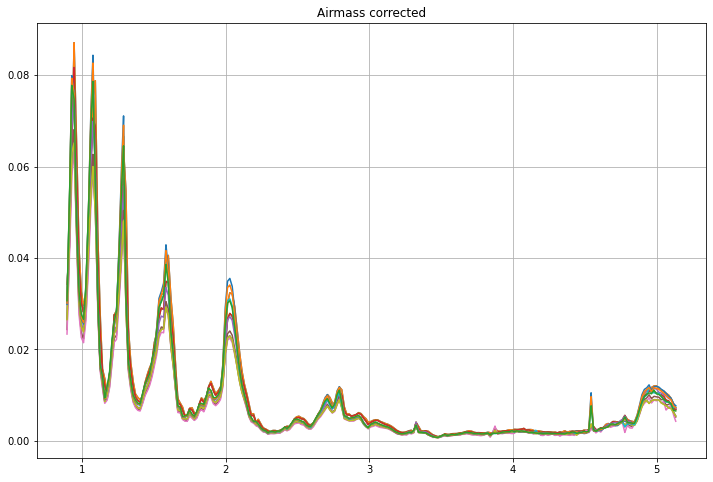

In [40]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
plt.title('Airmass corrected')
for i in range(13):
    plt.plot(xnew,air_list[i])
plt.grid()
plt.show()

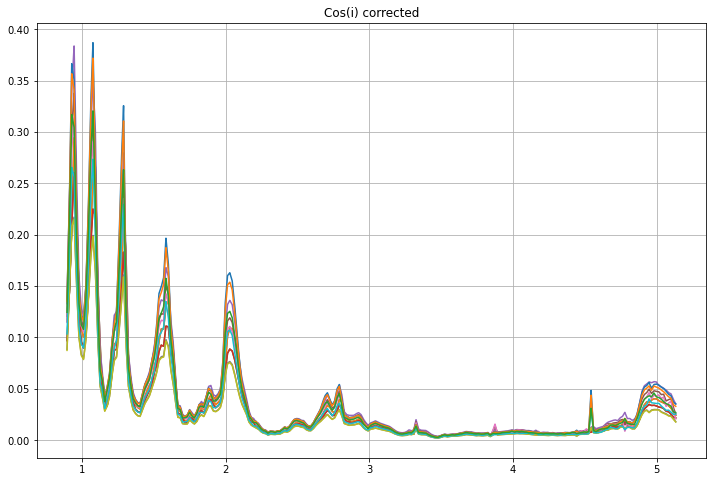

In [41]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))
plt.title('Cos(i) corrected')
for i in range(13):
    plt.plot(xnew,inc_list[i])
plt.grid()
plt.show()

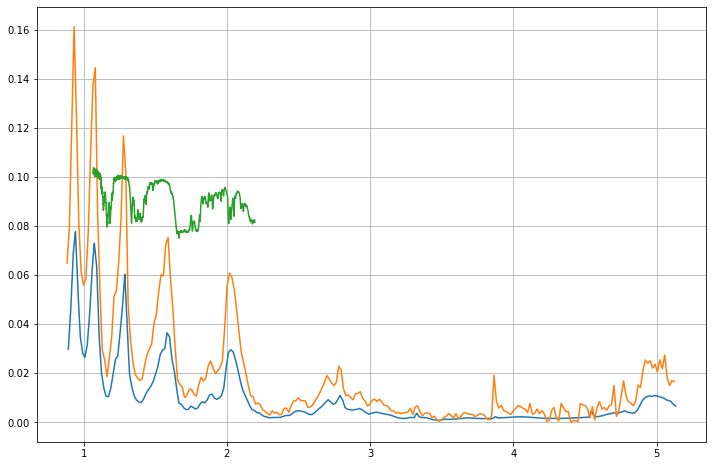

In [44]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))

average = np.average(airmass_data['spectrum'],axis=0)
ethane = np.load('ethane.npy')

plt.plot(xnew,average)
plt.plot(vims_2004,spec_0405[1])
plt.plot(ethane[:,0],ethane[:,14]/1000)
plt.grid()
plt.show()

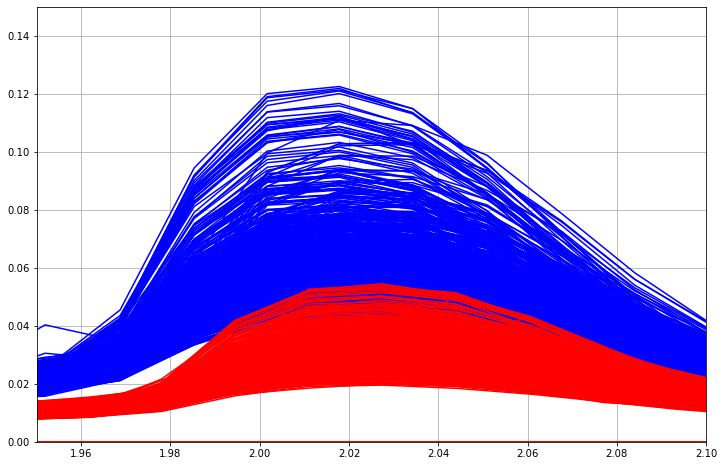

In [46]:
%matplotlib inline
plt.figure(facecolor='white',figsize=(12,8))

for  i in range(len(all_spectra[::10])):
    plt.plot(vims_wave,np.abs(all_spectra[i*10]),c='blue')
for i in range(len(airmass_data['spectrum'][::10])):
    plt.plot(xnew,airmass_data['spectrum'][i*10],c='red')

plt.xlim([1.95,2.1])
plt.ylim([0,0.15])
plt.grid()
plt.show()